In [1]:
from astropy import constants as const
from astropy import units as u
from random import *
from scipy.stats import stats
from scipy.stats import norm
import scipy.integrate as integrate
from iminuit import Minuit
import pysynphot as S
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0   

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [2]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from regions import CircleSkyRegion

result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg')
Circle = CircleSkyRegion(positions, 3.5 * u.deg)

# Cadence

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)

In [4]:
df_2018a = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv', index_col = 0)

In [5]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [6]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

In [7]:
#Distribution t_0

NYEARS = 10
NDAYS = NYEARS*365.25
from scipy.stats import uniform
xmin = 0
xmax = NDAYS
N = 1000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N)+ df["observationStartMJD"][0]

#plt.hist(list_t0,bins=int(NDAYS));
#plt.xlabel("$t_0$ (jours)")
#plt.title("Distribution des $t_0$")

In [8]:
#Distribution u0

N = 1000
uminmin = 0
uminmax = 3
umin = uniform.rvs(uminmin,uminmax,N)

#plt.hist(umin,bins=100)
#plt.xlabel("$u_{min}$")
#plt.ylabel("$p(u_{min})$")
#plt.title("Densité de probabilité de $u_{min}$")

In [9]:
#relative angular source-lens separation

def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [10]:
#Amplitude

def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [11]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

In [12]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4)

In [13]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

In [14]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [15]:
D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)
Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)


In [16]:
F_b = []
N_pe = []
bp_atmo = []
all_obs = []
all_count = []
sigma_N = []
amp_err = []
all_bp = []

for i in range (len(df['observationStartMJD'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_2018a.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)


for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);
    
for obs in all_obs :
    
    all_count.append(obs.countrate())

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((z * Observation 66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 68)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 69)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Observation 142)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 143)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 144)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 145)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 146)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 147)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 148)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 149)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 220)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 221)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 222)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 223)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 224)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 225)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 226)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 227)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 299)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 300)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 301)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 302)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 303)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 304)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 305)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 306)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 364)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 365)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 366)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 367)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 368)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 369)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 370)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 371)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 444)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 445)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 446)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 447)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 448)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 449)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 450)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 451)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 525)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 526)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 527)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 528)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 529)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 530)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 531)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 532)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 608)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 609)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 610)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 611)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 612)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 613)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 614)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 615)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 702)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 703)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 704)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 705)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 706)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 707)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 708)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 709)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 792)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 793)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 794)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 795)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 796)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 797)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 798)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 799)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 884)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 885)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 886)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 887)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 888)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 889)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 890)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 891)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [17]:
for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

In [18]:
for i in range (len(F_b)) :
    
    if (df['filter'].values[i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'].values[i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))


In [19]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [20]:
sigma_N = []

for i in range (len(bp_atmo)) :
    
    sigma_N.append(np.sqrt(N[i]))

In [60]:
chi2 = []
chi2_linear = []
tE = 20
Delta_chi2 = []
Ndof = []
rejected_events = 0

for i in range (len(list_t0)) :
    
    t0 = list_t0[i]       
    u0 = umin[randrange(len(umin))]   #random u0 for every event 
    
    tmin = t0 - 5.*tE
    tmax = t0 + 5.*tE
    
    df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
    
    
    df_event_times = df_event["observationStartMJD"].values

    #x = df_event_times                                   # We consider every data point (no distinction between filters)
    
    #y_data = A(u(df_event_times))
    
    #Photometric Error
    x = []
    y_data = []
    amp_err = []

    for j in range (len(df['observationStartMJD'])) :
        
        if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
            amp_err.append(sigma_N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
            x.append(df["observationStartMJD"].values[j])
            y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
    y = y_data + amp_err * np.random.randn(len(x))


    least_squares = LeastSquares(x, y, amp_err, Ab)
    m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
    least_squares_linear = LeastSquares(x, y, amp_err, linear)
    m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

    m.migrad()
    m.hesse()
    m_linear.migrad()
    m_linear.hesse()
    

#Restrictive cuts 
    
    if (#len(x) > 1                                                # Ndof microlensing > 1                                           
        len(x) - m.nfit > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0                                           # Chi2 linear != 0
        and m.fval/(len(x) - m.nfit) < 2  ):                              # Goodness of fit chi2/Ndof < 2
        #and (m_linear.fval - m.fval)/(np.sqrt((len(x) - m.nfit))) > 20 ) :  
        
        Ndof.append(len(x) - m.nfit)
        
        chi2.append(m.fval)
         
        chi2_linear.append(m_linear.fval)
        
        Delta_chi2.append((m_linear.fval - m.fval)/(np.sqrt((2*(len(x)- m.nfit)))))
        
    else :
        
        rejected_events += 1

        
print(rejected_events)

405


Text(0, 0.5, 'chi2')

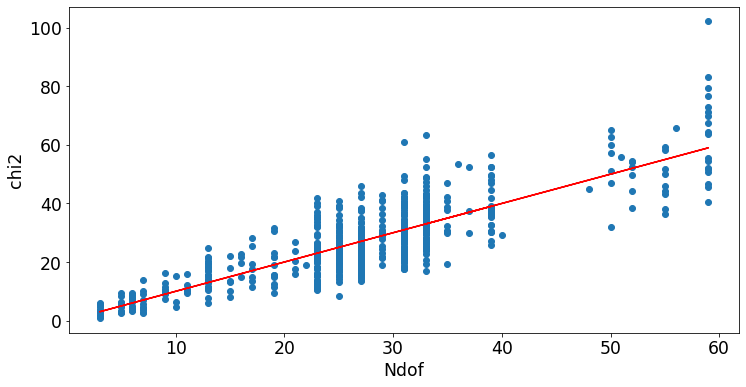

In [53]:
plt.plot(Ndof,Ndof, color = 'r')
plt.scatter(Ndof, chi2)
plt.xlabel("Ndof")
plt.ylabel("chi2")
#plt.xlim([0,20])
#plt.ylim([0,1])

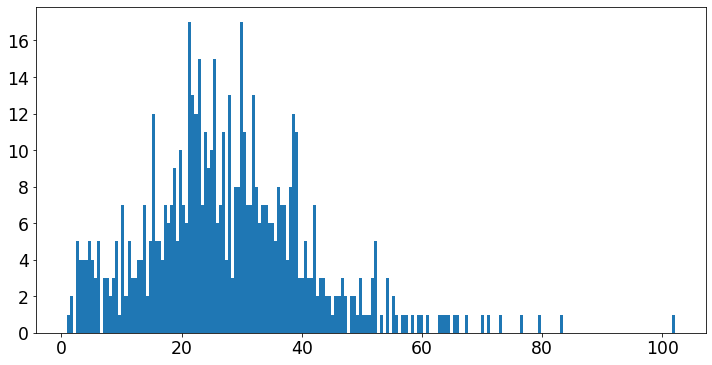

In [54]:
plt.hist(chi2, bins= 200);

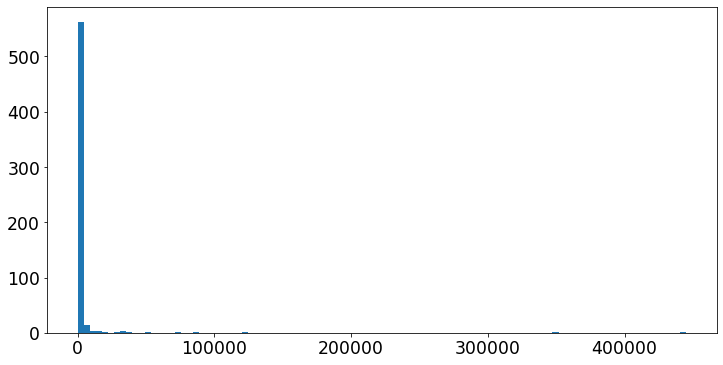

In [55]:
plt.hist(chi2_linear, bins = 100);

(0.0, 100.0)

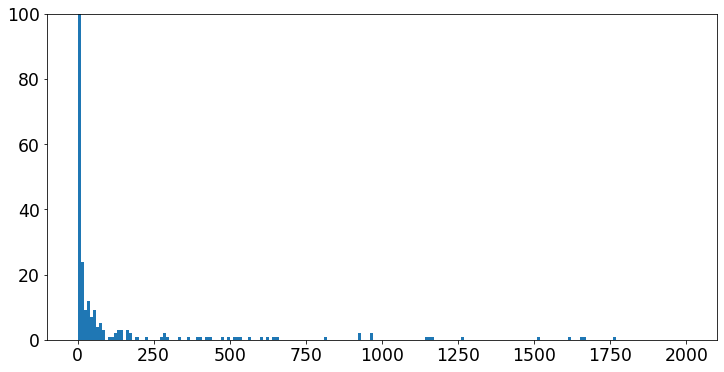

In [56]:
plt.hist(Delta_chi2, bins = 200, range = [0,2000])
plt.ylim(0,100)

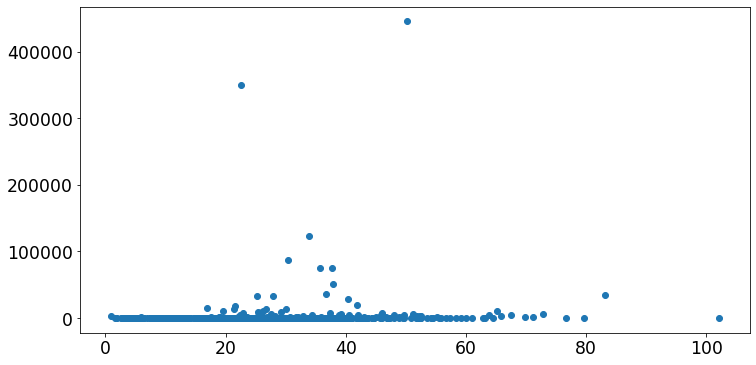

In [57]:
plt.scatter(chi2, chi2_linear)
#plt.ylim([0,200])